Here I test if conv nets can be used to detect patterns in movements.

For that I train CNN on the data, where each channel represents a feature, one row represents and observation and number of columns in that row coressponds to the number of timesteps.

In [190]:
import os
import sys

import numpy as np
import numpy.ma as ma
np.random.seed(42)

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Reload modules after they were changed 
%load_ext autoreload
%autoreload 2

from plot_helpers import plot_confusion_matrix, plot_path
from helpers import traject_to_coord
from data_preprocessing import denorm, norm_values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [460]:

# Load the data
x_data = np.load('data/x_data.npy')
y_data = np.load('data/y_data.npy')

# Fit the label encoder to our label series
encoder = LabelBinarizer()
y_data_hot = encoder.fit_transform(y_data)

# shuffle the data 
idxs = np.arange(len(x_data))
np.random.shuffle(idxs)
x_data = x_data[idxs]
y_data_hot = y_data_hot[idxs]

# expand dimensions in X data to make it: [N obs, 1 (rows), N timesteps (columns), N features (channels)]
# x_data = np.expand_dims(x_data, 1)
# Con1D input dimensions (batchSize, length, channels)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_hot, test_size=0.1, random_state=42)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print()

# compute class probability and set higher weight to rare classes to deal with unbalanced data
sample_weights = compute_sample_weight('balanced', y_train)
print("Classes weights and # of observations:")
for i in zip(*np.unique(sample_weights, return_counts=True)):
    print("\tobs. {},\b weigth: {:.2f}".format(i[1], i[0]))
print()
    
NUM_CLASSES = len(np.unique(y_data, axis=0))
TIMESTEPS = x_data.shape[1]
print("Number of classes:", NUM_CLASSES)
print("Timesteps per observation:", TIMESTEPS)

x_train shape: (227655, 30, 2)
y_train shape: (227655, 6)

227655 train samples
25295 test samples

Classes weights and # of observations:
	obs. 60606 weigth: 0.13
	obs. 54130 weigth: 0.15
	obs. 43686 weigth: 0.20
	obs. 39260 weigth: 0.23
	obs. 17438 weigth: 0.58
	obs. 12535 weigth: 0.82

Number of classes: 6
Timesteps per observation: 30


In [461]:
# Conv1D input dimensions (batchSize, length, channels)
input_shape = x_data.shape[1:]

model = Sequential()
model.add(Conv1D(32, kernel_size=3,
                 activation='relu',
                 input_shape=input_shape, 
                 padding='same',
                 name='conv1', 
                 strides=1))
model.add(MaxPooling1D(pool_size=2, name='pool1'))
model.add(Conv1D(64, 3, activation='relu', padding='same', name='conv2'))
model.add(MaxPooling1D(pool_size=2, name='pool2'))
model.add(Conv1D(128, 3, activation='relu', padding='same', name='conv3'))
model.add(MaxPooling1D(pool_size=2, name='pool3'))
model.add(Flatten(name='flatten1'))
model.add(Dropout(0.25, name='dropout1'))
model.add(Dense(128, activation='sigmoid', name='fc1'))
model.add(Dropout(0.25, name='dropout2'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='fc2'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 30, 32)            224       
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 15, 32)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 15, 64)            6208      
_________________________________________________________________
pool2 (MaxPooling1D)         (None, 7, 64)             0         
_________________________________________________________________
conv3 (Conv1D)               (None, 7, 128)            24704     
_________________________________________________________________
pool3 (MaxPooling1D)         (None, 3, 128)            0         
_________________________________________________________________
flatten1 (Flatten)           (None, 384)               0         
__________

In [462]:
batch_size = 1024
epochs = 300
MODEL_PATH = 'data/conv1d_model.h5'

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          min_delta=0, patience=100, verbose=0, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_acc', verbose=0, 
                                             save_best_only=True, mode='max')

callbacks = [checkpoint] #, earlystop]

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          sample_weight=sample_weights,
          callbacks=callbacks)

score = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 227655 samples, validate on 25295 samples
Epoch 1/300
227655/227655 [==============================] - 6s 25us/step - loss: 0.4314 - acc: 0.1091 - val_loss: 1.8234 - val_acc: 0.0981
Epoch 2/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.4214 - acc: 0.1284 - val_loss: 1.8206 - val_acc: 0.1133
Epoch 3/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.4168 - acc: 0.1340 - val_loss: 1.7768 - val_acc: 0.1346
Epoch 4/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.4136 - acc: 0.1557 - val_loss: 1.7696 - val_acc: 0.1778
Epoch 5/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.4112 - acc: 0.1759 - val_loss: 1.7757 - val_acc: 0.1787
Epoch 6/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.4095 - acc: 0.1860 - val_loss: 1.7478 - val_acc: 0.1940
Epoch 7/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.4076 - acc: 0.1930 - val_

Epoch 59/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3703 - acc: 0.2965 - val_loss: 1.6256 - val_acc: 0.2959
Epoch 60/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3702 - acc: 0.2957 - val_loss: 1.6479 - val_acc: 0.2967
Epoch 61/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3698 - acc: 0.2984 - val_loss: 1.6329 - val_acc: 0.2944
Epoch 62/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3688 - acc: 0.2996 - val_loss: 1.6357 - val_acc: 0.2920
Epoch 63/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3684 - acc: 0.3002 - val_loss: 1.6371 - val_acc: 0.2862
Epoch 64/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3683 - acc: 0.2992 - val_loss: 1.6166 - val_acc: 0.2998
Epoch 65/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3676 - acc: 0.3002 - val_loss: 1.6393 - val_acc: 0.2885
Epoch 66/300


Epoch 117/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3518 - acc: 0.3160 - val_loss: 1.6047 - val_acc: 0.3063
Epoch 118/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3511 - acc: 0.3173 - val_loss: 1.6271 - val_acc: 0.2947
Epoch 119/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3513 - acc: 0.3156 - val_loss: 1.6159 - val_acc: 0.3009
Epoch 120/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3507 - acc: 0.3173 - val_loss: 1.6288 - val_acc: 0.2910
Epoch 121/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3510 - acc: 0.3173 - val_loss: 1.6209 - val_acc: 0.2927
Epoch 122/300
227655/227655 [==============================] - 5s 20us/step - loss: 0.3503 - acc: 0.3164 - val_loss: 1.6349 - val_acc: 0.2902
Epoch 123/300
227655/227655 [==============================] - 5s 21us/step - loss: 0.3504 - acc: 0.3172 - val_loss: 1.6115 - val_acc: 0.3066
Epoch 

KeyboardInterrupt: 

In [463]:
# model.save(MODEL_PATH)
model = load_model(MODEL_PATH)

In [464]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)

             precision    recall  f1-score   support

     search       0.15      0.38      0.21      1954
         vk       0.34      0.42      0.38      4344
       wiki       0.17      0.53      0.26      1440
       news       0.35      0.27      0.31      4843
       maps       0.58      0.23      0.33      6656
    youtube       0.41      0.27      0.33      6058

avg / total       0.40      0.31      0.32     25295



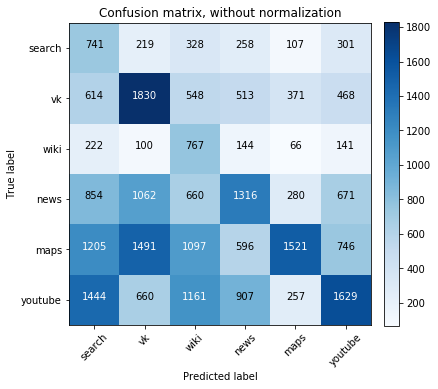

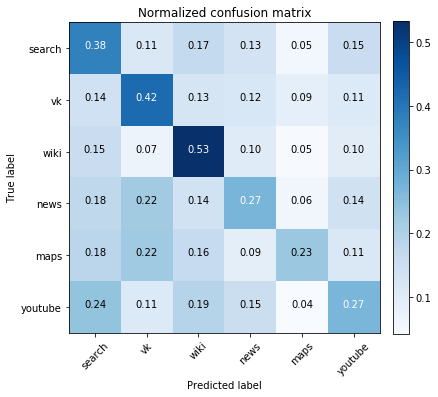

In [465]:
# Confusion Matrix
target_names = ['search', 'vk', 'wiki', 'news', 'maps', 'youtube']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

p = plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
p = plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Visualize filters

In [466]:
# model layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

dict_keys(['conv2', 'conv1', 'fc1', 'pool3', 'dropout1', 'flatten1', 'conv3', 'pool2', 'dropout2', 'fc2', 'pool1'])

## Get activations

In [467]:
def plot_conv1_filter(model, fn, layer='conv1', clip=False, filter_size=3):
    """Plot filter representation based on filter weights"""
    W = [l.get_weights()[0] for l in model.layers if l.name == layer][0]
    W = np.squeeze(W)
    W = np.moveaxis(W, 2, 0) 

    # scale weights to [0 1]
    x_min = np.min(W)
    x_max = np.max(W)
    #W = (W - x_min) / (x_max - x_min)
    
    filter_weights = W[fn, ...]

    move_dir = denorm(filter_weights[:, 0], x_max=np.pi*2)
    move_len = denorm(filter_weights[:, 1], x_max=1.44/filter_size)

    xy = traject_to_coord(move_dir, move_len, x_init=0.5, y_init=0.5)
    p = plot_path(xy, screen_lims=False, show_joints=True, clip=clip)
    return p, filter_weights



To make the operation compatible, we will arrange our filter to 1x9. Now, if we do a matrix multiplication over our stretched image and filter, we will have 1x100 image as a result, which we could reshape it back to 10x10 or 1x1x10x10 image.

In [468]:
def convolve_1d(string, kernel, padding=False, step=1):
    """Convolve 1d vector with the kernel"""
    
    k_s = len(kernel)
    # kernel = np.flip(kernel, axis=0)      # Flip the kernel
    
    if padding:
        # Add zero padding to the input 
        string_padded = np.zeros(string.shape[0] + 2)   
        string_padded[1:-1] = string
    else:
        string_padded = string
    
    output = [] # convolution output
        
    # Loop over every value of the input
    for x in range(0, string_padded.shape[0] - k_s + 1, step):    
        # element-wise multiplication of the kernel and the input
        out = (kernel * string_padded[x : x + k_s]).sum() 
        output.append(out)
    output = np.asarray(output)
    
    return output


def convolve_1d_channels(string_ch, kernel, padding=False, step=1):
    """Convolve 2d array (values, channels) with the kernel.
    Return output (activations, channels)"""
    output = []
    for i in range(string_ch.shape[1]):
        ch_out = convolve_1d(string_ch[..., i], kernel[..., i], padding=padding, step=step)
        output.append(ch_out)
    output = np.vstack(output).T
    
    return output

In [472]:
def plot_filter(fn, n_obs=10000):
    
    p, f = plot_conv1_filter(model, fn)
    filter_size = f.shape[0]

    np.random.seed(42)
    paths = np.random.rand(n_obs*filter_size, 2)  

    # find trajectories for the data
    move_dir = denorm(paths[..., 0], x_max=np.pi*2).reshape(n_obs, filter_size)
    move_len = denorm(paths[..., 1], x_max=1/3).reshape(n_obs, filter_size)
    xy = [traject_to_coord(move_dir[i], move_len[i], 0.5, 0.5) for i in range(n_obs)]
    xy = np.asarray(xy).reshape(n_obs*(filter_size+1), 2)

    # convert to segments and drop unwanted connections (every 4th segment)
    segments = np.array(list(zip(xy[:-1], xy[1:])))
    idx_delete = np.arange(filter_size, n_obs*(filter_size+1)-1, filter_size+1)
    segments = np.delete(segments, idx_delete, axis=0)

    # filer activation
    acts = np.sum(convolve_1d_channels(paths, f, padding=False, step=filter_size), axis=1)
    tr = np.percentile(acts, 95)
    top_n = 100
    tr_top = np.sort(acts)[::-1][top_n]
    
    print("Filter:\n", f)
    print("Q threshold: {:.2f}".format(tr))
    print("Top-{} threshold: {:.2f}".format(top_n, tr_top))
    plt.show()
    
    # expand activations to segments size and filter segm by threshold
    weights = np.repeat(acts, filter_size)
    segments = segments[weights > tr]
    weights = weights[weights > tr]

    ## plot heatmap 
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(filter_size):
        dir_1_idx = np.arange(i, segments.shape[0], filter_size)
        dir_1_xy = segments[dir_1_idx][:, 1]
        dir_1_xy =  np.vstack([dir_1_xy, [0, 0], [1, 1]]) # add corner values

        heatmap, xedges, yedges = np.histogram2d(dir_1_xy[:, 0], dir_1_xy[:, 1], bins=100)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        ax[i].imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
        ax[i].plot(0.5, 0.5, marker='+', markersize=10, color='orange', linestyle='None')
        ax[i].invert_yaxis()
        ax[i].set_title("{} segment".format(i+1))
    plt.suptitle("Direction heatmap for segments in top {} trajectories".format(len(weights)/filter_size), y=1.04)
    plt.tight_layout()
    plt.show()

    segments = segments[weights > tr_top]
    weights = weights[weights > tr_top]

    ## plot top trajectories which activate filter
    p = plot_path(segments, segments_weights=weights, figsize=(12, 8), show_joints=True, screen_lims=False,
                  change_width=False, clip=False, feed_lines=True, alpha=0.75)
    plt.show()

In [90]:
# Generate data to test filter activation
test_images = []

for i in range(1, 4):

    directions = np.repeat(np.pi/i, TIMESTEPS)
    dir_norm = norm_values(directions, 0, 2 * np.pi)

    lenghts = np.repeat(1/TIMESTEPS, TIMESTEPS)
    len_norm = norm_values(lenghts, 0, 1.44)
    im = np.vstack([dir_norm, len_norm]).T # (37944, 1, 30, 2)
#     im = np.expand_dims(im, 0)
    im = np.expand_dims(im, 0)
    test_images.append(im)

test_images = np.vstack(test_images)
print(test_images.shape)

(3, 30, 2)


In [98]:
%autoreload 2
from keras_helpers import *

conv1 (25295, 30, 32)


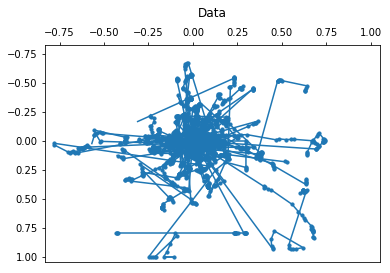

FILTER # 0
Filter:
 [[-0.43  0.7 ]
 [-0.02  0.04]
 [-0.07  0.29]]
Q threshold: 0.67
Top-100 threshold: 0.79


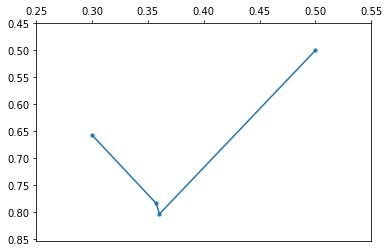

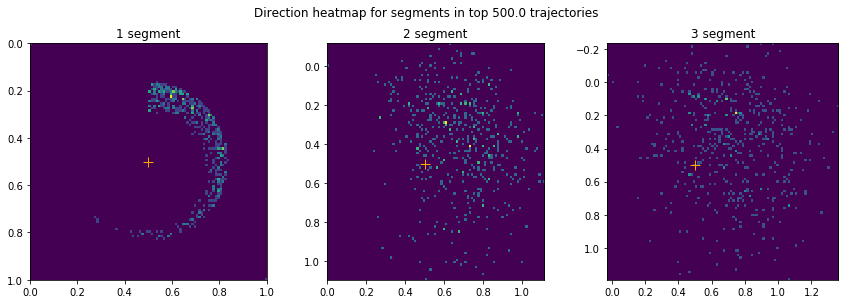

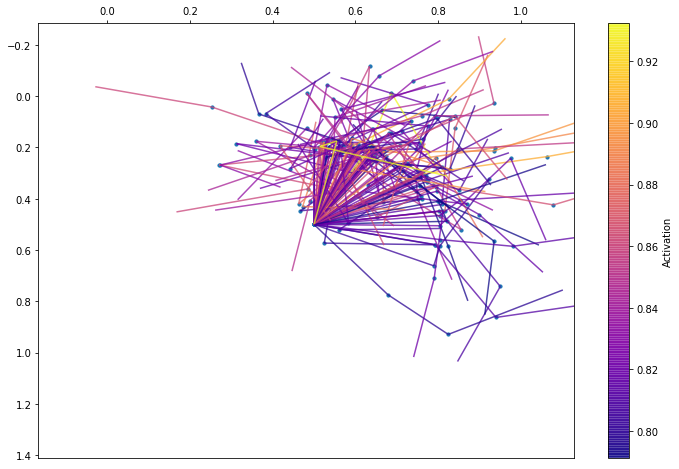

filter activations 0


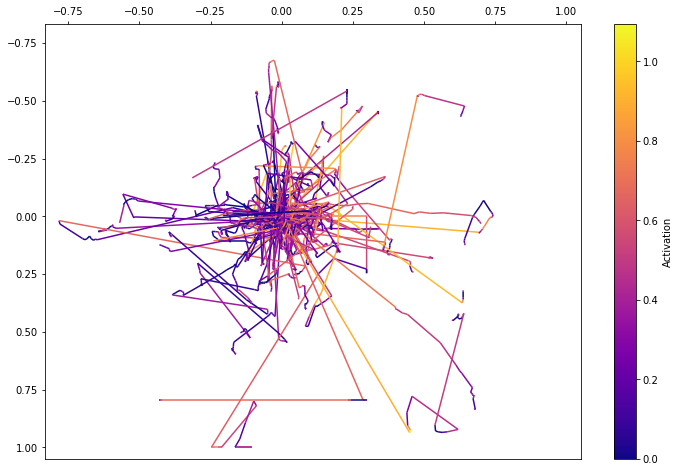

FILTER # 1
Filter:
 [[ 0.07  1.84]
 [ 0.12  2.01]
 [-0.2   0.24]]
Q threshold: 3.35
Top-100 threshold: 3.72


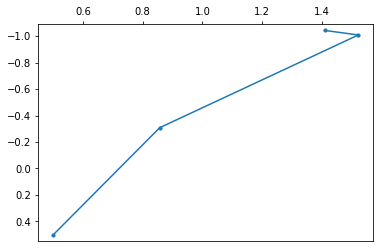

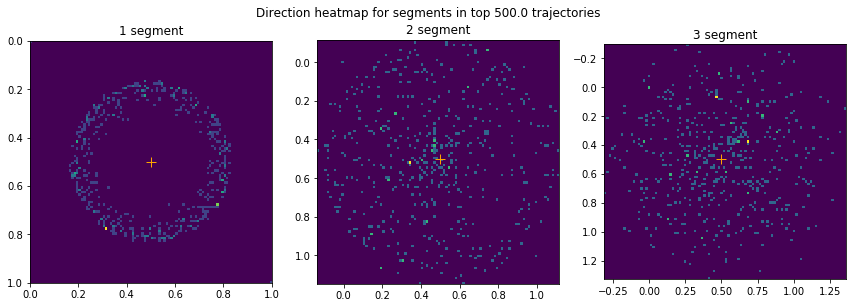

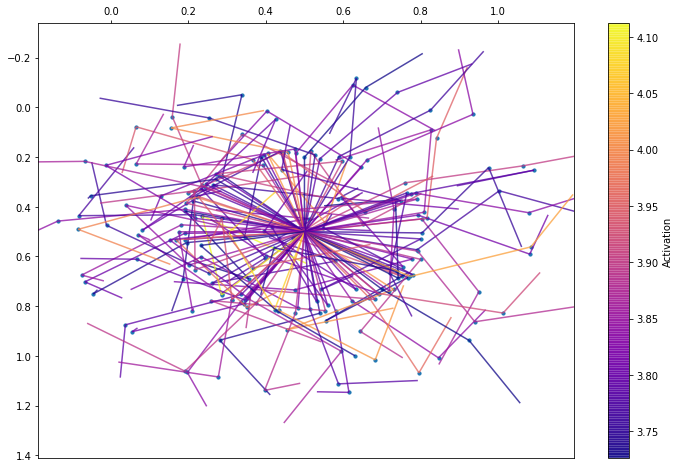

filter activations 1


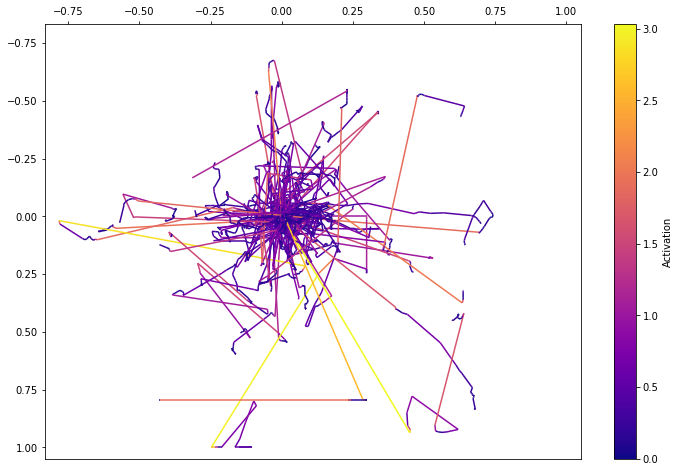

FILTER # 2
Filter:
 [[ 0.1  -3.01]
 [ 0.29 -1.8 ]
 [-0.14 -0.93]]
Q threshold: -1.01
Top-100 threshold: -0.52


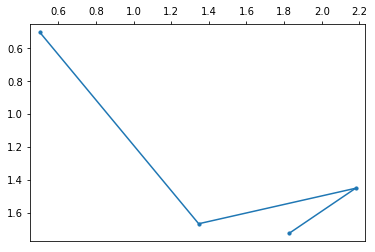

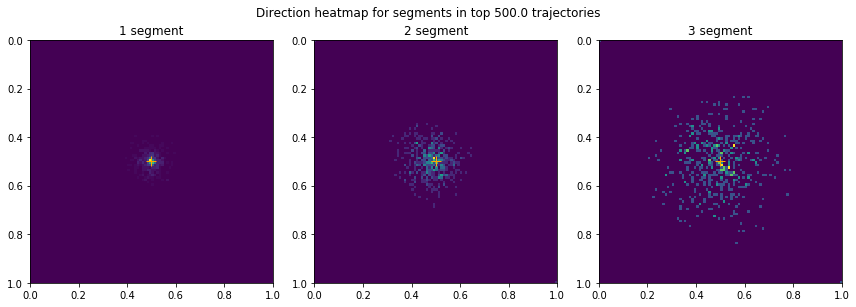

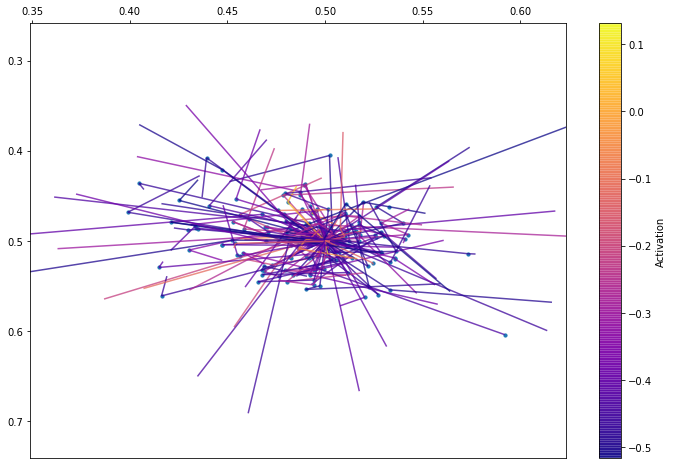

filter activations 2


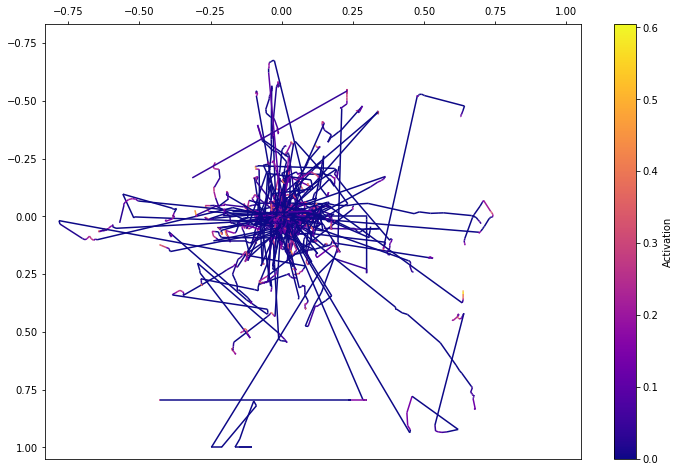

FILTER # 3
Filter:
 [[  5.18e-01   9.70e-01]
 [  7.29e-02   1.11e-01]
 [ -6.44e-04   9.07e-01]]
Q threshold: 1.97
Top-100 threshold: 2.18


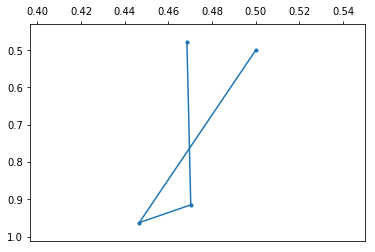

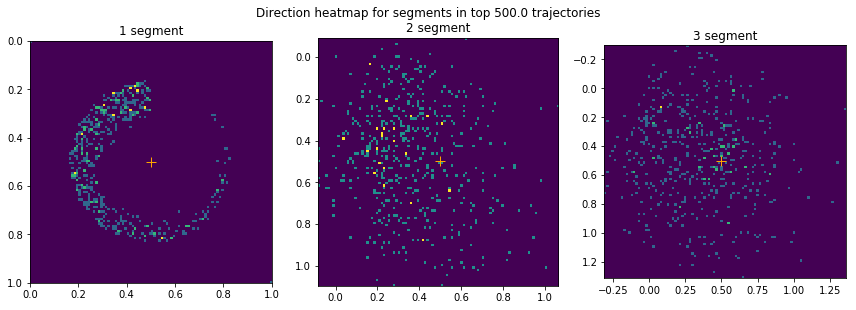

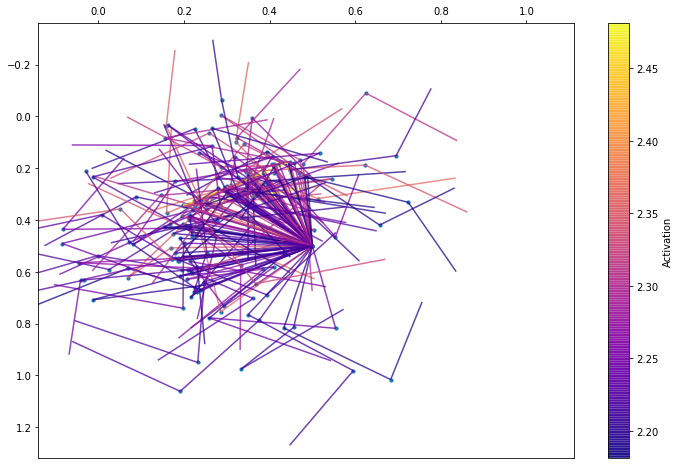

filter activations 3


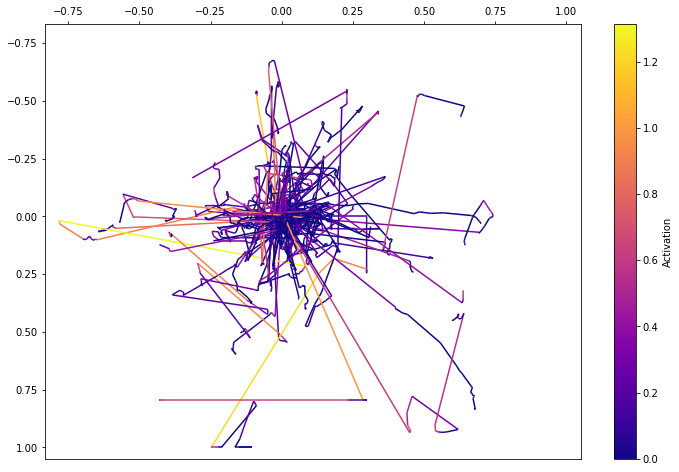

FILTER # 4
Filter:
 [[ 0.15 -0.07]
 [-0.11  0.56]
 [ 0.38  1.52]]
Q threshold: 2.00
Top-100 threshold: 2.20


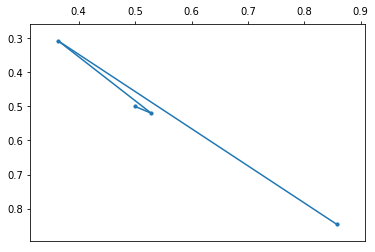

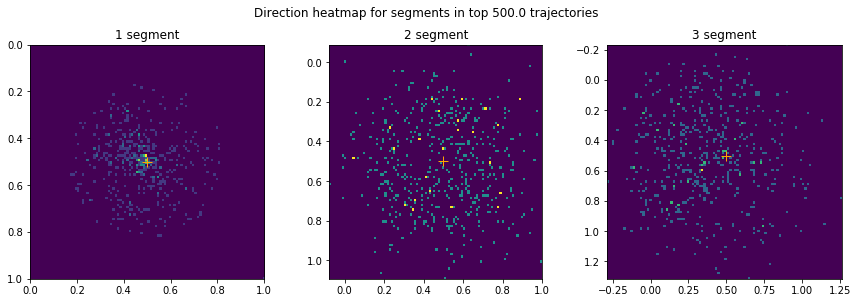

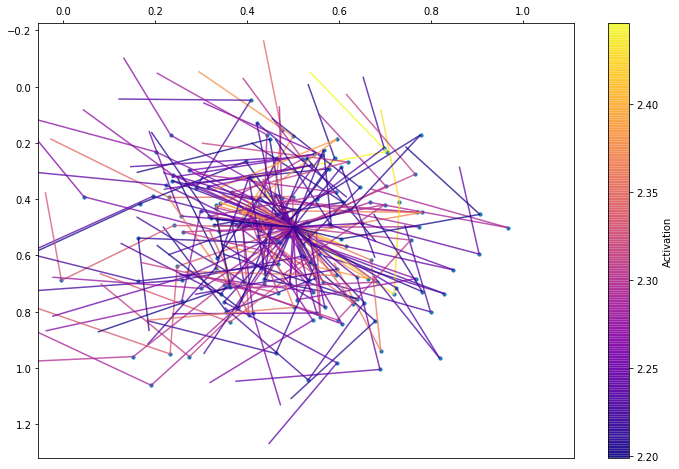

filter activations 4


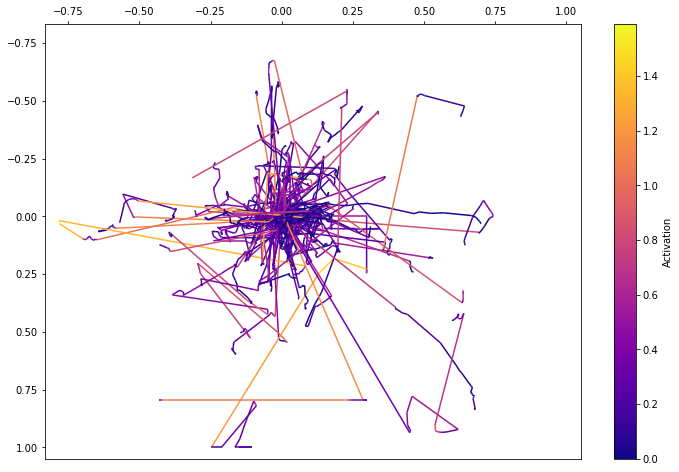

FILTER # 5
Filter:
 [[-0.02  0.49]
 [ 0.07  1.81]
 [-0.04  2.21]]
Q threshold: 3.66
Top-100 threshold: 4.01


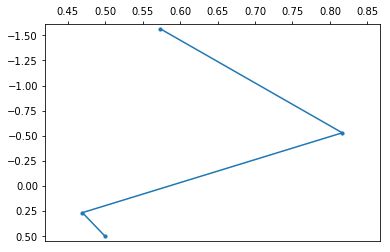

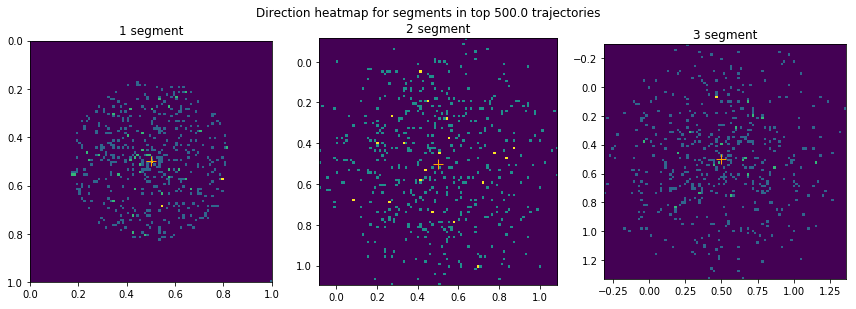

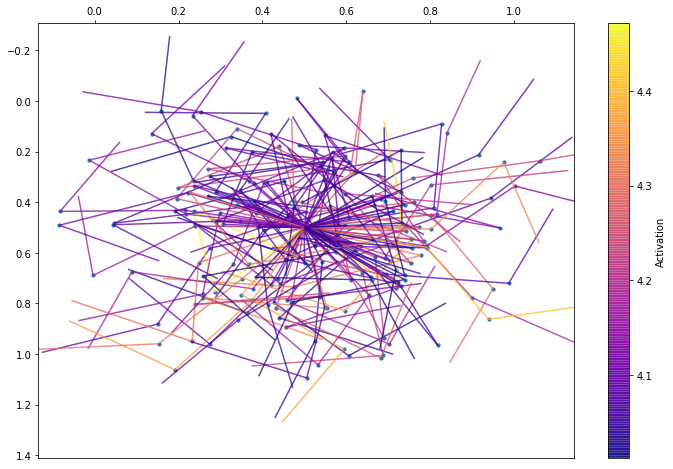

filter activations 5


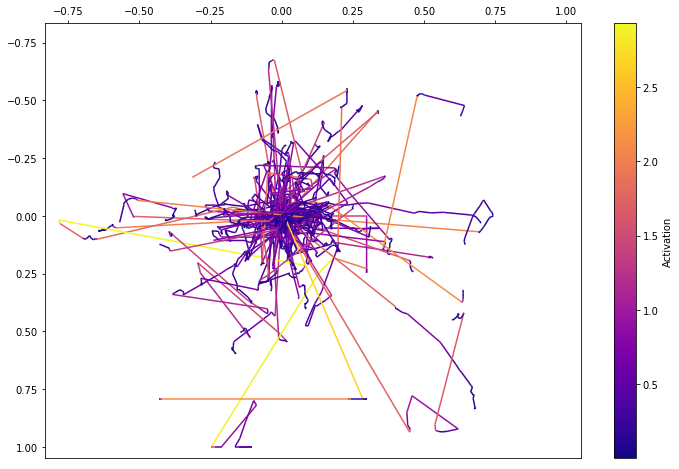

FILTER # 6
Filter:
 [[ 0.39 -1.94]
 [-0.31  0.65]
 [-0.07  0.47]]
Q threshold: 0.60
Top-100 threshold: 0.84


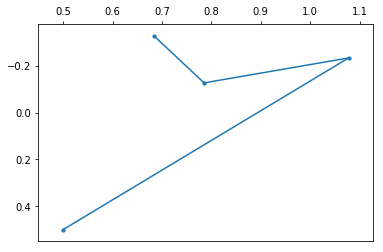

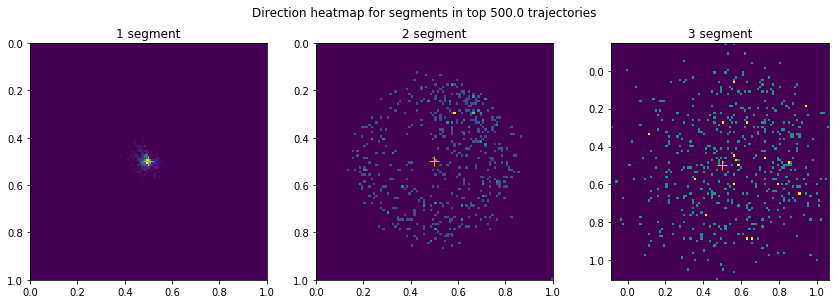

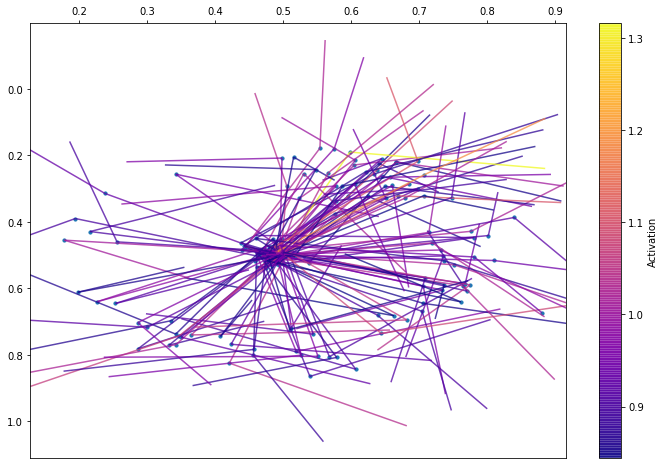

filter activations 6


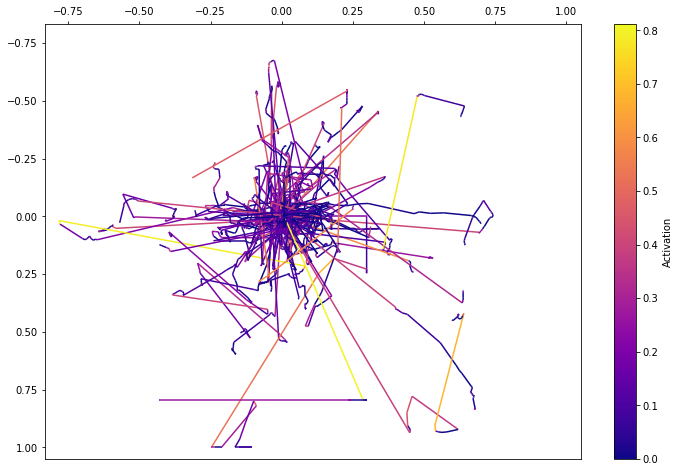

FILTER # 7
Filter:
 [[ 0.02  1.26]
 [-0.   -0.52]
 [ 0.02  1.31]]
Q threshold: 1.94
Top-100 threshold: 2.21


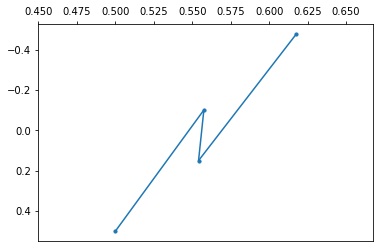

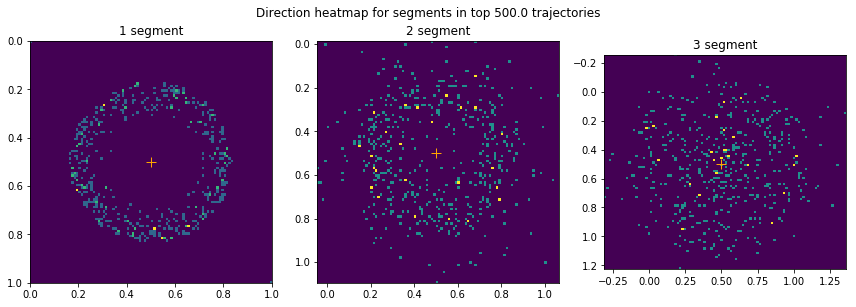

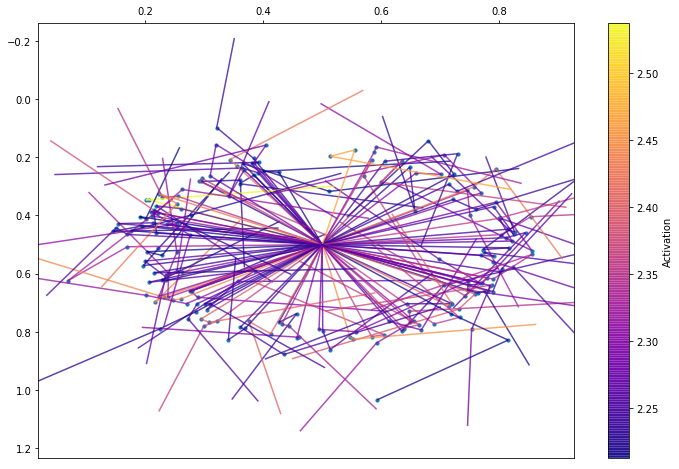

filter activations 7


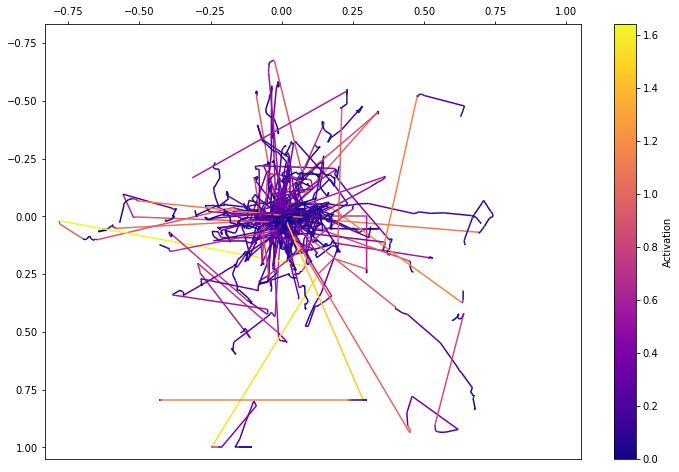

FILTER # 8
Filter:
 [[ 0.07  1.16]
 [-0.4  -0.48]
 [-0.48  0.72]]
Q threshold: 1.05
Top-100 threshold: 1.30


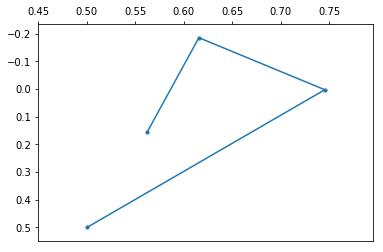

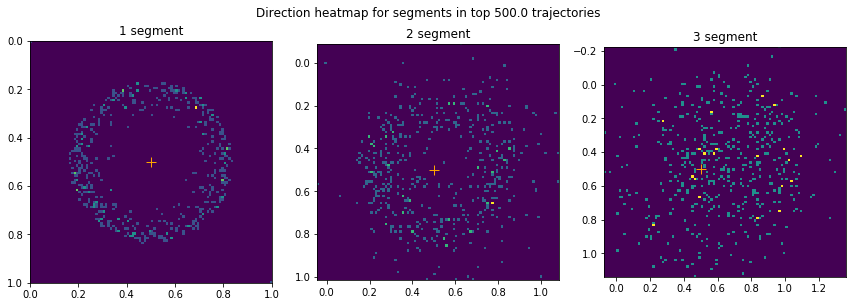

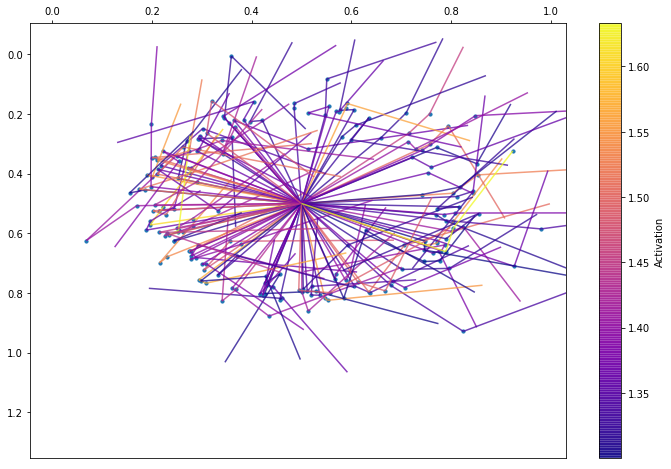

filter activations 8


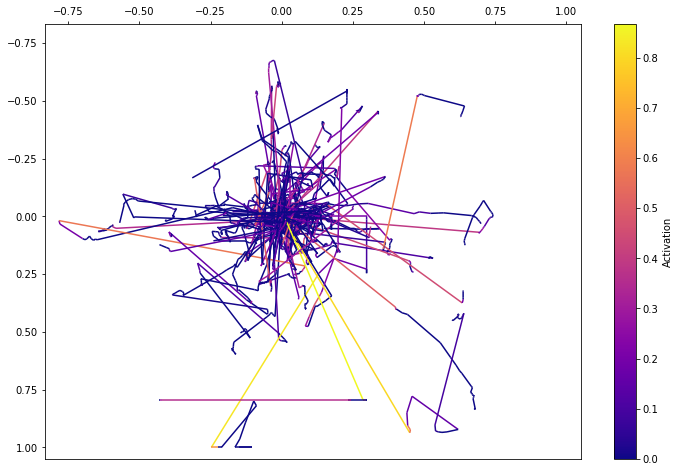

FILTER # 9
Filter:
 [[ 0.12 -0.15]
 [ 0.54  0.29]
 [-0.33 -0.21]]
Q threshold: 0.49
Top-100 threshold: 0.61


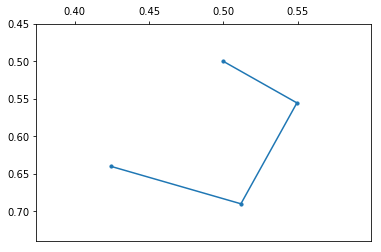

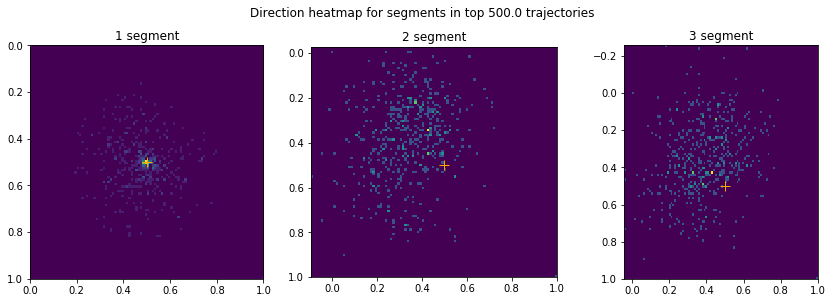

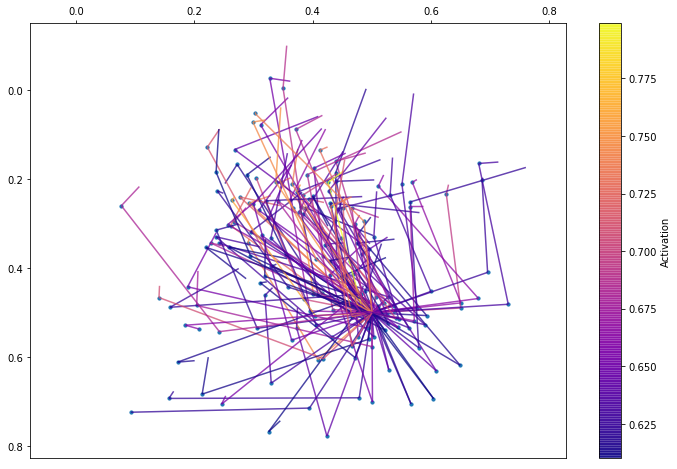

filter activations 9


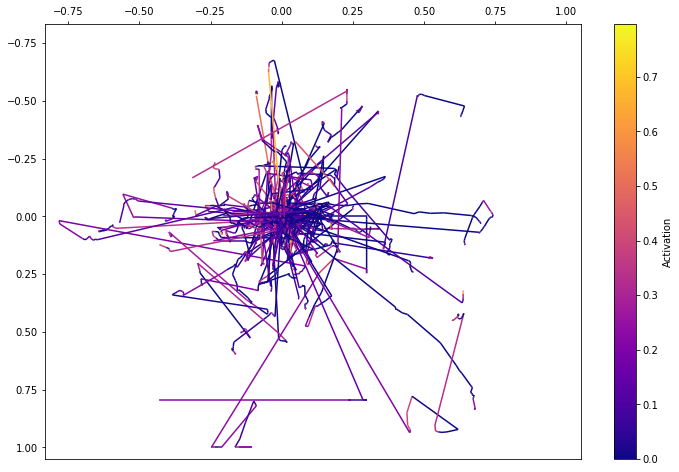

In [473]:
# Visualize filters and their activations on the input sequence
l = 'conv1'
num_obs = 100
shift = 0
num_filters = 10 #activations[l].shape[-1]
data = x_test #test_images

# get activations for the data
activations = get_activations(model, data, layers=[l])
for k, v in activations.items():
    print(k, v.shape)

# convert data observations into paths
lines = []
for i in range(num_obs):
    path = data[shift+i, ...]
    move_dir = denorm(path[:, 0], x_max=np.pi*2)
    move_len = denorm(path[:, 1], x_max=1.44)
    xy = traject_to_coord(move_dir, move_len)
    segments = list(zip(xy[:-1], xy[1:]))
    lines.append(segments)
lines = np.concatenate(lines)

# plot data 
p = plot_path(lines, feed_lines=True, screen_lims=False, title='Data', show_joints=True, clip=False)
plt.show()

# plot filters and their activations
for f in range(num_filters):
    
    print("filter #".upper(), f)
    plot_filter(f, n_obs=10000)
    
    print("filter activations", f)
    
    fw = np.concatenate([activations[l].squeeze()[i, :, f] for i in range(num_obs)])
    if not np.all(fw == 0):
        fw = filter_act_to_input(fw, model, l, len(fw))
        
    p = plot_path(lines, segments_weights=fw, figsize=(12, 8), change_width=False, clip=False, feed_lines=True)
    plt.show()

In [106]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in np.arange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


W shape :  (32, 2, 3)


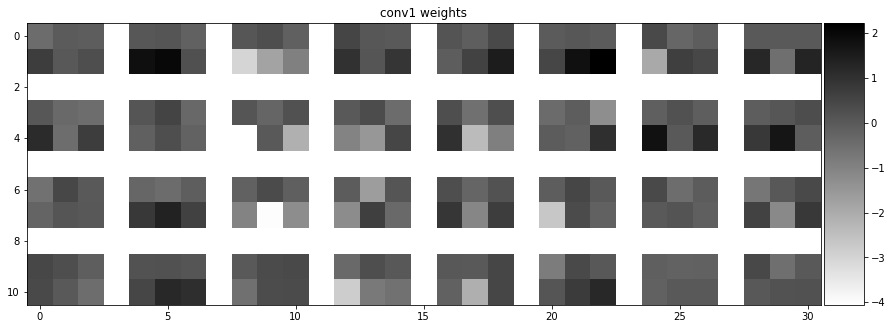

In [474]:
# Visualize weights
W = model.layers[0].get_weights()[0]
W = np.squeeze(W).swapaxes(0, 2)
print("W shape : ", W.shape)


plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W, 4, 8), cmap=plt.cm.binary)